## Dataset edition and manipulation 

In [5]:
import pandas as pd
import matplotlib.pyplot as plt

In [1]:
with open("all_stories.txt", "r", encoding="utf-8") as f:
    dataset = f.read()

In [2]:
print("Length of the dataset:", len(dataset))

Length of the dataset: 3173379


In [4]:
chars = sorted(list(set(dataset)))
vocab_size = len(chars)
print("".join(chars))
print("Vocab size:", vocab_size)


 !"'()*,-./012345689:;?ABCDEFGHIJKLMNOPQRSTUVWYZ[]_abcdefghijklmnopqrstuvwxyz
Vocab size: 78


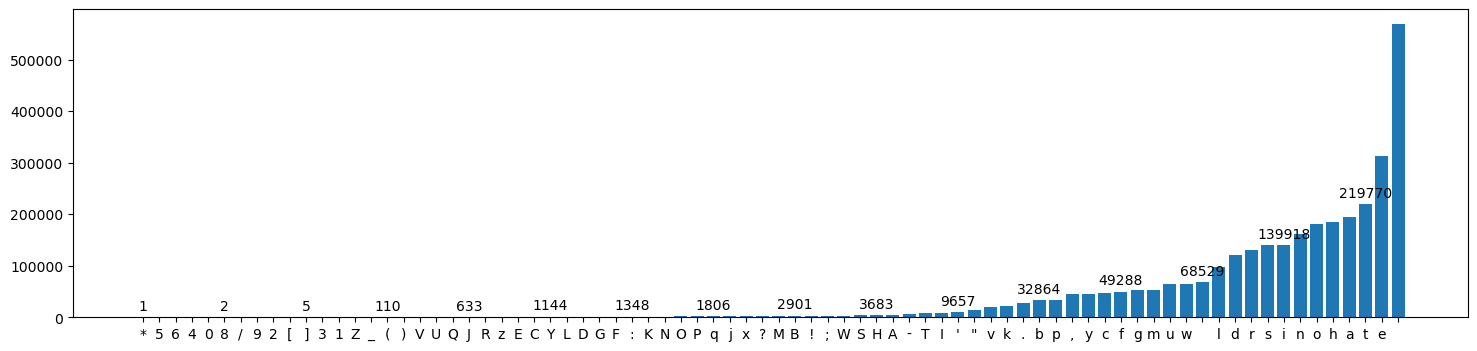

In [54]:
from collections import Counter

fig = plt.figure(figsize=(18,4))
counter = Counter(dataset)
counter = {char: count for char, count in sorted(counter.items(), key=lambda item: item[1])}
axs = plt.bar([i for i in range(len(counter))],counter.values())
for k, bar in enumerate(axs):
    if k % 5 == 0:
        height = bar.get_height()
        plt.annotate(f'{height}', xy=(bar.get_x() + bar.get_width() / 2, height), xytext=(0, 3),
        textcoords="offset points", ha='center', va='bottom')
plt.xticks([i for i in range(len(counter))],counter.keys())
plt.show()


In [44]:
# Mapping from vocab chars to ints 
# Very small vocal size tokenizer, gpt-2 uses 50k 
str2int = {ch:i for i, ch in enumerate(chars)}
int2str = {i:ch for i, ch in enumerate(chars)}
encode = lambda s: [str2int[c] for c in s]
decode = lambda l: "".join([int2str[i] for i in l])

print(encode("Test string!"))
print(decode(encode("Test string!")))

[43, 56, 70, 71, 1, 70, 71, 69, 60, 65, 58, 2]
Test string!


In [51]:
import torch

data = torch.Tensor(encode(dataset)).to(torch.int64)
print("data Tensor shape:", data.shape)

data Tensor shape: torch.Size([3173379])


In [52]:
# Split training / validation at 85%
n = int(0.85 * len(data))
train_data = data[:n]
val_data = data[:n]

In [53]:
# maximum block size defines the maximum number of encoded ints the model takes for a prediction
# one block contains multiple examples for training at each position, for N chars there are N-1 examples 
block_size = 8
train_data[:block_size+1] 

tensor([43, 59, 56, 69, 56,  1, 74, 56, 69])

In [60]:
torch.manual_seed(42)

batch_size = 4

def get_batch(split):
    # generate a batch of data at input X and target Y
    data = train_data if split == "train" else val_data
    ix = torch.randint(len(data) - block_size, (batch_size, ))
    x = torch.stack([data[i:i+block_size] for i in ix])
    y = torch.stack([data[i+1:i+block_size+1] for i in ix])
    return x, y

xb, yb = get_batch("train")
print("Input:\n", xb)
print("Output:\n", yb)

for b in range(batch_size):
    for t in range(block_size):
        context = xb[b, :t+1]
        target = yb[b, t]
        print(f"Context: {context.tolist()}, Target: {target}")
    break

Input:
 tensor([[56, 52, 69,  1, 54, 66, 66, 62],
        [56, 65, 71, 56, 55,  1, 53, 56],
        [76, 66, 72,  1, 52,  1, 70, 71],
        [54, 62, 63, 56, 55,  9,  9,  3]])
Output:
 tensor([[52, 69,  1, 54, 66, 66, 62,  8],
        [65, 71, 56, 55,  1, 53, 56, 54],
        [66, 72,  1, 52,  1, 70, 71, 52],
        [62, 63, 56, 55,  9,  9,  3, 35]])
Context: [56], Target: 52
Context: [56, 52], Target: 69
Context: [56, 52, 69], Target: 1
Context: [56, 52, 69, 1], Target: 54
Context: [56, 52, 69, 1, 54], Target: 66
Context: [56, 52, 69, 1, 54, 66], Target: 66
Context: [56, 52, 69, 1, 54, 66, 66], Target: 62
Context: [56, 52, 69, 1, 54, 66, 66, 62], Target: 8


## Language Model 

In [70]:
import torch
import torch.nn as nn
from torch.nn import functional as F
torch.manual_seed(42)

# Model only predicting from one char 
class BigramLanguageModel(nn.Module):
    def __init__(self, vocab_size):
        super().__init__()
        # Each token directly rteads off the logits for thenext token from a lookup table 
        self.token_embedding_table = nn.Embedding(vocab_size, vocab_size)
    
    def forward(self, idx, targets=None):
        # idx and targets are (B, T) tensors of ints
        #  every int in idx takes out one row of length vocab_size from the embedding table
        logits = self.token_embedding_table(idx) # (B, T, C)

        if targets is None:
            loss = None
        else:
            B, T, C = logits.shape
            logits = logits.view(B*T, C)
            targets = targets.view(-1) # same as B*T
            loss = F.cross_entropy(logits, targets)
        return logits, loss

    def generate(self, idx, max_new_tokens):
        # idx is (B, T) array of indices in the current context
        for _ in range(max_new_tokens):
            logits, loss = self(idx)
            # Only get the last time dim step
            logits = logits[:, -1, :]
            probs = F.softmax(logits, dim=1)
            # sample one from the distribution
            idx_next = torch.multinomial(probs, num_samples=1)
            # append index to running idx sequence
            idx = torch.cat((idx, idx_next), dim=1) # (B, T+1)
        return idx

m = BigramLanguageModel(vocab_size)
logits, loss = m(xb, yb)
print(logits.shape)
# We expect the loss to be -ln(1/vocab_size) aprox 4.35
# The loss is higher so we have more entropy, the model is guessing wrongly
print(loss)

# Generate from the model (not trained yet)
idx = torch.zeros((1, 1), dtype=torch.long) # start sequence with a 0 eq. to "\n"
print(decode(m.generate(idx, max_new_tokens=100)[0].tolist()))

torch.Size([32, 78])
tensor(4.7229, grad_fn=<NllLossBackward0>)

LR jocNzx-tR,j!qSkt/JsW5mY2KSkJKSW4AD1SkhFrAB8.*xsM"xw5aqZBK-:6 *3Zfbdk(w1jzte:IWEfGz-*eC/c nA6
D;R-


## Train the Bigram Model (simplest model)

In [71]:
optimizer = torch.optim.Adam(m.parameters(), lr=1e-3)

In [74]:
batch_size = 32
for steps in range(5000):
    xb, yb = get_batch("train")

    logits, loss = m(xb, yb)
    optimizer.zero_grad(set_to_none=True)
    loss.backward()
    optimizer.step()

print(loss.item())

2.3443987369537354


In [76]:
idx = torch.zeros((1, 1), device=device, dtype=torch.long)
print(decode(m.generate(idx, max_new_tokens=300)[0].tolist()))


jr



sor theroue pinq3Rst athe Z66C/Ug,'PZC/gin h'le ime iverouto ischomonthabund toomily ?_?-s Pr lor, l, b*3U1Nend or.
s.0.Thin sirouthinx_?'Ofo therotheng topmer d wait t le e t lleye fruleacld therDg o. ben bP:



Mangitheran o,'Mo an bed athe wej"Y; ame a
Swat of Swo th. antodis nowales D"Do m
